# 三角形绘制

> 本章节算法和代码引用了  Dmitry V. Sokolov 的 [tinyrenderer](https://github.com/ssloy/tinyrenderer) 第二章三角形光栅化过程。在原算法的基础上，本章节做了整理、改进和重构。感谢 Dmitry V. Sokolov 将这一段算法整理成册，并开源地发布在 GitHub 供所有人使用。

在上一章节中，我们描述了基本的线段绘制的算法。线段是所有直线，射线，以及曲线的基本构成单元。对于一条曲线来说，我们可以通过利用微积分的思想，将曲线转换为一条一条细小的线段，通过控制线段的数量来控制曲线的平滑精度。而对于一个曲面来说，我们则可以通过渲染无数个细小的三角形来拟合。

我们在此章节中，将会探索在 2D 平面下的三角形渲染。在掌握了 2D 三角形渲染的方法以后，对于一个立体的 3D 图形，无非通过投影变换将三维空间转换为二维平面，然后重复这个渲染过程。

In [1]:
%%capture

# 执行第二章的代码，引入 draw_line 函数
%run "02-line.ipynb"

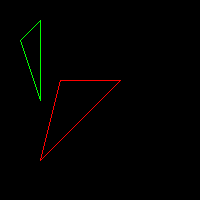

In [2]:
def draw_triangle_frame(img, p1, p2, p3, color):
  draw_line(img, p1, p2, color)
  draw_line(img, p2, p3, color)
  draw_line(img, p3, p1, color)

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_triangle_frame(img, (0.2, 0.2), (0.6, 0.6), (0.3, 0.6), (255, 0, 0, 255))
draw_triangle_frame(img, (0.2, 0.5), (0.1, 0.8), (0.2, 0.9), (0, 255, 0, 255))
display(img)

运行该程序我们就可以得到一个空心三角形。

## 扫描线算法

通过线段绘制的办法，我们已经得到了一个空心的三角形。而对于实心三角形来说，一个朴素的想法是，我们从下至上，如同填色一样，一条线一条线的补全颜色，直到绘制完成整个三角形。

由于我们不断的在三角形内部从左至右扫描并填，这个算法被称之为扫描线算法。现在让我们来讨论扫描线算法的实现细节。

第一步，我们将三角形切分为上下两部分。

![Split Triangle](assets/03-triangle/split-triangle.png)

如上图所示，红色的三角形被经过B点的水平线，分成了上下两部分。上部分三角形由线段 AC，BC 和水平线 BD 围成，下半部分三角形则由 AC，AB 和水平线BD围成。A，B，C 三点的确定只需要根据三角形的三个端点的 y 坐标从低到高排序即可。

如果 A 和 B 处于同一水平线，y 值相等，那么我们可以认为其下半部分 ABD（或上半部分 BDC ）为空三角形，而只存在上半部分（或下半部分）三角形。

经过如此切分以后，三角形的三条线段的方程都是已知的。那么我们关注三角形 ABD，我们下往上，在线段 AD 上寻找一个点，然后做水平线，与 AB 相交，这条线段即我们的扫描线。这根扫描线明显处于三角形内部，那么我们把其经过的所有像素着色即可。


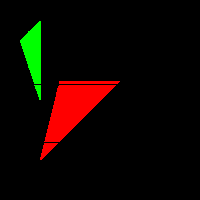

In [17]:
# 已知线段的两个端点，当一个点在线段上，并已知其y值，求x值
def solve_line_x(p1, p2, y):
    # p1.y和p2.y应不相等，我们在扫描线循环中，规避了相等情况
    assert p1[1] != p2[1]
    t = (y - p1[1]) / (p2[1] - p1[1])
    return t * (p2[0] - p1[0]) + p1[0]

def draw_triangle(img, p1, p2, p3, color):
    # 将屏幕坐标转换到像素空间
    p1i = (int(p1[0] * img.size[0]), int(p1[1] * img.size[1]))
    p2i = (int(p2[0] * img.size[0]), int(p2[1] * img.size[1]))
    p3i = (int(p3[0] * img.size[0]), int(p3[1] * img.size[1]))
    
    # 将三角形三个坐标按y轴从低到高排序
    if p1i[1] > p2i[1]:
        p1i, p2i = p2i, p1i
    if p1i[1] > p3i[1]:
        p1i, p3i = p3i, p1i
    if p2i[1] > p3i[1]:
        p2i, p3i = p3i, p2i
    
    # 扫描下半部分三角形，如果三角形水平，p1i.y == p2i.y, 则该循环被跳过
    for y in range(p1i[1], p2i[1]):
        x_min = solve_line_x(p1i, p3i, y) / img.size[0]
        x_max = solve_line_x(p1i, p2i, y) / img.size[0]
        if x_min == x_max:
            continue
        y = y / img.size[1]
        draw_line(img, (x_min, y), (x_max, y), color)
    
    # 扫描上半部分三角形，如果三角形水平，p2i.y == p3i.y, 则该循环被跳过
    for y in range(p2i[1], p3i[1]):
        x_min = solve_line_x(p1i, p3i, y) / img.size[0]
        x_max = solve_line_x(p2i, p3i, y) / img.size[0]
        if x_min == x_max:
            continue
        y = y / img.size[1]
        draw_line(img, (x_min, y), (x_max, y), color)

w, h = 200, 200
img = Image.new('RGBA', (w, h), 'black')
draw_triangle(img, (0.2, 0.2), (0.6, 0.6), (0.3, 0.6), (255, 0, 0, 255))
draw_triangle(img, (0.2, 0.5), (0.1, 0.8), (0.2, 0.9), (0, 255, 0, 255))
display(img)